## <center>Banking Credit Risk Analysis</center>

### <center>Case Study</center>

"Bank Loan Approval-Refusal Prediction," focuses on leveraging advanced model building and data analytics to enhance loan approval processes in the financial industry. By analyzing historical data and borrower profiles, it aims to develop a robust predictive framework, offering valuable insights and recommendations for more informed, data-driven lending decisions.

### Business Problem: 
The project focuses on improving the credit approval process by identifying eligible applicants and managing credit limits effectively. Using historical data and applicant details like income and employment history, it aims to build predictive models that reduce loan defaults, boost profitability, and ensure responsible lending across credit products.

### Import packages:

In [1]:
# import the packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy.stats as stats

import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score

### Data Availability:

In [2]:
bankloans = pd.read_csv("E:\CS\DS360\DS360-20230716T150307Z-001\DS360\Data Science 360\Data Science 360\Python\BankLoan Logistic Regression\BankLoan Logistic Regression\Bankloans.csv")
bankloans.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


### Creating UDF for the summary of Numeric data:

In [3]:
def continuous_var_summary( x ):
    
    # freq and missings
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total
    
    # outliers - iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr
    
    
    return pd.Series( [ x.dtype, x.nunique(), n_total, x.count(), n_miss, perc_miss,
                       x.sum(), x.mean(), x.std(), x.var(), 
                       lc_iqr, uc_iqr, 
                       x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                       x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max() ], 
                     
                    index = ['dtype', 'cardinality', 'n_tot', 'n', 'nmiss', 'perc_miss',
                             'sum', 'mean', 'std', 'var',
                        'lc_iqr', 'uc_iqr',
                        'min', 'p1', 'p5', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99', 'max']) 

### Detection of outliers & missing values:

In [4]:
bankloans.apply(continuous_var_summary)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
dtype,int64,int64,int64,int64,int64,float64,float64,float64,float64
cardinality,37,5,33,32,129,245,842,848,2
n_tot,850,850,850,850,850,850,850,850,850
n,850,850,850,850,850,850,850,850,700
nmiss,0,0,0,0,0,0,0,0,150
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.647059
sum,29775,1454,7281,7116,39674,8645.9,1340.284021,2616.970979,183.0
mean,35.029412,1.710588,8.565882,8.371765,46.675294,10.171647,1.576805,3.078789,0.261429
std,8.041432,0.927784,6.777884,6.895016,38.543054,6.719441,2.12584,3.398803,0.439727
var,64.664623,0.860783,45.939706,47.541251,1485.566998,45.150891,4.519196,11.551864,0.19336


###  Missing value imputation for categorical and continuous variables

        not applicable in the current problem, as we don't have any missing values in the X variables.

In [5]:
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    return

### EDA:

In [6]:
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


#### Cardinality of y variable, i.e. default 

In [7]:
bankloans.nunique()

age          37
ed            5
employ       33
address      32
income      129
debtinc     245
creddebt    842
othdebt     848
default       2
dtype: int64

In [8]:
bankloans.default.value_counts()

0.0    517
1.0    183
Name: default, dtype: int64

#### %age of records in each category of default:

In [9]:
print("%age of records in each category of default:\n")

bankloans.default.value_counts() / bankloans.default.count()

%age of records in each category of default:



0.0    0.738571
1.0    0.261429
Name: default, dtype: float64

* **THIS ABOVE STEP IS DONE TO CHECK THE DATA BALANCING:**
        
        If any category %age data < 20%, we need to performing data balancing.
        
     CASE-1:
     
         0 : 80% 
         1 : 20%
                 
                 No data balancing needed
     
     CASE -2 :  ( NP.RANDOM() )
         
         0 : 85%       
         1 : 15%
         
         Here data balancing is needed as categ 1  < 20%.
         There are 3 ways to balance the data:
                 
                   OVER BALANCING           UNDER BALANCING       OVER-UNDER BALANCING
                 
        0: 85%    0 : 85%                      0 :  15%           0 : 40% OR 50%
        1: 15%    1 : 85%                      1 :  15%           1 : 40% OR 50%

### SEPARATE THE ACTUAL DATASET AS EXISTING & NEW CUSTOMERS:

In [10]:
bankloans_existing = bankloans[ bankloans.default.notna() ]
bankloans_new = bankloans[ bankloans.default.isna() ]

In [11]:
bankloans_existing.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [12]:
bankloans_new.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN


### EDA for existing customers:

#### Summary of the Existing customers:

In [13]:
bankloans_existing.apply(continuous_var_summary)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
dtype,int64,int64,int64,int64,int64,float64,float64,float64,float64
cardinality,37,5,32,31,114,231,695,699,2
n_tot,700,700,700,700,700,700,700,700,700
n,700,700,700,700,700,700,700,700,700
nmiss,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,24402,1206,5872,5795,31921,7182.4,1087.486972,2140.746028,183.0
mean,34.86,1.722857,8.388571,8.278571,45.601429,10.260571,1.553553,3.058209,0.261429
std,7.997342,0.928206,6.658039,6.824877,36.814226,6.827234,2.117197,3.287555,0.439727
var,63.957482,0.861566,44.329483,46.578939,1355.287265,46.611118,4.482523,10.808015,0.19336


### DATA PREP:

##### Treating outliers:

In [14]:
bankloans_existing = bankloans_existing.apply(lambda x : x.clip(lower = x.quantile(0.01), 
                                           upper = x.quantile(0.99)))
bankloans_existing.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41.0,3,17.0,12.0,176.0,9.3,9.891428,5.008608,1.0
1,27.0,1,10.0,6.0,31.0,17.3,1.362202,4.000798,0.0
2,40.0,1,15.0,14.0,55.0,5.5,0.856075,2.168925,0.0
3,41.0,1,15.0,14.0,120.0,2.9,2.658720,0.821280,0.0
4,24.0,2,2.0,0.0,28.0,17.3,1.787436,3.056564,1.0


##### Summary of the updated existing customers:

In [15]:
bankloans_existing.apply(continuous_var_summary)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
dtype,float64,int64,float64,float64,float64,float64,float64,float64,float64
cardinality,34,4,29,28,107,221,683,687,2
n_tot,700,700,700,700,700,700,700,700,700
n,700,700,700,700,700,700,700,700,700
nmiss,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,24393.07,1201,5851.07,5771.07,31394.1,7155.507,1049.190134,2119.103279,183.0
mean,34.847243,1.715714,8.358671,8.244386,44.848714,10.222153,1.498843,3.02729,0.261429
std,7.954735,0.906523,6.566008,6.721915,31.942133,6.68216,1.788451,3.115401,0.439727
var,63.277806,0.821784,43.112459,45.18414,1020.29987,44.651264,3.198555,9.705723,0.19336


##### Handling missing values:

In [16]:
# bankloans_existing = bankloans_existing.apply(lambda x: missing_imputation(x))

### Co-relations of the variables:

In [18]:
Correlation_Banks = bankloans_existing.corr()
Correlation_Banks.to_csv("E:\CS\DS360\DS360-20230716T150307Z-001\DS360\Data Science 360\Data Science 360\Python\BankLoan Logistic Regression\BankLoan Logistic Regression\Correlations_Banks.csv")

<Axes: >

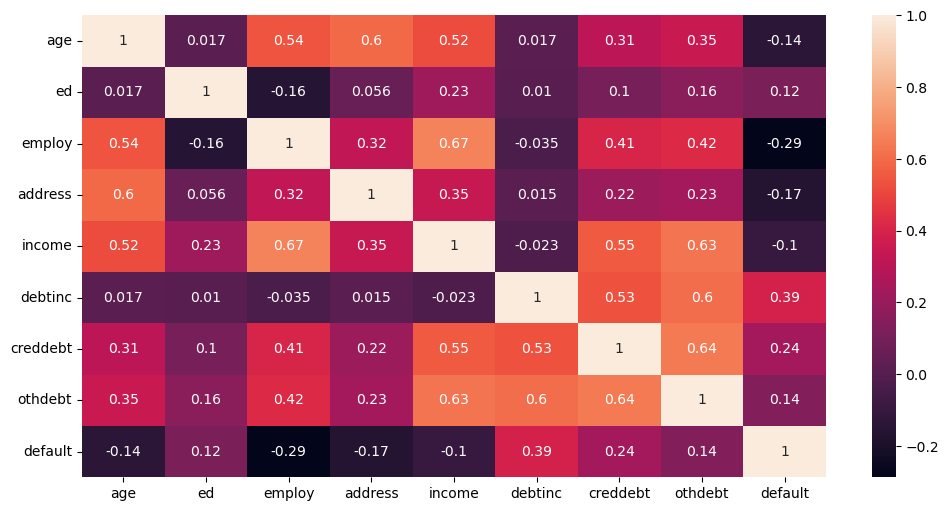

In [19]:
# Heatmap on co-relations:

plt.figure(figsize= (12,6))
sns.heatmap(Correlation_Banks, annot = True)

### MODEL BUILDING:

#### MODEL 1: Considering all variables, i.e. before variable selections

##### I. Train-test split:

In [20]:
train, test = train_test_split(bankloans_existing, test_size = 0.3,
                               train_size =0.7, random_state = 42)

In [21]:
train.head(3)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
357,24.0,2,0.0,2.0,15.0,16.1,0.321195,2.093805,1.0
649,29.0,2,5.0,7.0,28.0,18.7,2.125816,3.110184,0.0
291,33.0,4,9.0,8.0,32.0,5.5,0.496320,1.263680,0.0


In [22]:
test.head(3)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
158,33.0,1,9.0,4.0,29.0,13.8,1.348674,2.653326,1.0
500,22.0,3,0.0,1.0,18.0,7.7,0.478170,0.907830,0.0
396,34.0,1,14.0,8.0,28.0,17.0,1.137640,3.622360,0.0


##### II. Define & fit the model on train data:

In [23]:
# model equation in the form of :   y ~ x1 + x2 + x3 +.....

model_eq = 'default ~ ' + ' + '.join(bankloans_existing.columns.difference(['default']))
model_eq

'default ~ address + age + creddebt + debtinc + ed + employ + income + othdebt'

In [24]:
# define the model:

m0 = smf.logit(formula = model_eq ,data =  train)

In [25]:
# fit the model:

m0 = m0.fit()

Optimization terminated successfully.
         Current function value: 0.426055
         Iterations 7


##### III. Summary of the model:

In [26]:
print( m0.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.274     
Dependent Variable: default          AIC:              434.6822  
Date:               2023-09-03 17:36 BIC:              472.4135  
No. Observations:   489              Log-Likelihood:   -208.34   
Df Model:           8                LL-Null:          -287.15   
Df Residuals:       480              LLR p-value:      5.0203e-30
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.3775    0.7359  -1.8717  0.0612  -2.8198   0.0649
address       -0.0852    0.0258  -3.3009  0.0010  -0.1357  -0.0346
age            0.0388    0.0202   1.9213  0.0547  -0.0008   0.0784
creddebt       0.6408    0.138

* **Pseudo R squared value is called SOMARS'D SCORE. Ideally, the somars'd should be  <= 0.2**

#### Data Exploratory Analysis
    - Variable Reduction using Somer's D values
    - Bi-variate analysis technique to check the predictive power of each independent against dependent
    - cutoff is 0.2 or 20% below which the variable is insignificant

### VARIABLE REDUCTIONS:
                
                1. Feature Selection ----> somars'd score >= 0.2
                2. Multi-Colinearity ----> VIF()

#### 1. Feature Selection

##### Get the Somars'D for all the x variable individually:

In [27]:
# Get a dataframe which consists of:
# x variables, concordance, somars'd score

somarsd_score = pd.DataFrame()

for i in bankloans_existing.columns.difference(['default']) :
    
    # i. define & fit the model:
    log_mod = smf.logit('default ~ '+ i, bankloans_existing).fit()
    
    # ii. predict the y values:
    y_pred_prob = log_mod.predict(bankloans_existing)
    
    # iii. Get the concordance | roc_auc_score:
    concordance = roc_auc_score(bankloans_existing.default, y_pred_prob)
    
    # iv. Get the somar'd score:
    somarsd = 2*concordance - 1

    # v. Save the above measures in temp data:
    temp_data = pd.DataFrame([i, concordance, somarsd]).T
    
    # vi. Saving everything in final dataframe:
    somarsd_score = pd.concat([temp_data, somarsd_score], axis =  0, ignore_index = True)
    
    
somarsd_score.columns = [ 'Variables', 'Concordance', 'SomarsD_Score']

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


In [28]:
somarsd_score

,Variables,Concordance,SomarsD_Score
0,othdebt,0.586903,0.173806
1,income,0.600136,0.200273
2,employ,0.704569,0.409138
3,ed,0.574151,0.148302
4,debtinc,0.735253,0.470506
5,creddebt,0.636189,0.272378
6,age,0.603165,0.206329
7,address,0.611192,0.222384


* **From the above output, significant variables are those which have somars'D score >= 0.2**

In [29]:
features = list( somarsd_score.loc[somarsd_score.SomarsD_Score >= 0.2 , 'Variables'] )
features

['income', 'employ', 'debtinc', 'creddebt', 'age', 'address']

#### MODEL-2 : after performing Variable reductions & multi-colinearity check:

In [30]:
features

['income', 'employ', 'debtinc', 'creddebt', 'age', 'address']

In [31]:
##### Creating model equation, defining & fitting the model:  y ~ x1+x2+x3+...

model_eq = 'default ~ ' +  ' + '.join(features)

m2 = smf.logit(model_eq, data = train).fit()

Optimization terminated successfully.
         Current function value: 0.427646
         Iterations 7


In [32]:
#### Model summary:  .summary2()

print(m2.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.272     
Dependent Variable: default          AIC:              432.2375  
Date:               2023-09-03 17:36 BIC:              461.5841  
No. Observations:   489              Log-Likelihood:   -209.12   
Df Model:           6                LL-Null:          -287.15   
Df Residuals:       482              LLR p-value:      4.0260e-31
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.7907    0.5986  -2.9914  0.0028  -2.9640  -0.6174
income         0.0019    0.0076   0.2556  0.7983  -0.0129   0.0167
employ        -0.2564    0.0364  -7.0454  0.0000  -0.3277  -0.1851
debtinc        0.0733    0.023

#### MODEL-3 : after choosing significant variables.

In [33]:
features = ['employ', 'debtinc', 'creddebt', 'address']
features

['employ', 'debtinc', 'creddebt', 'address']

In [34]:
##### Creating model equation, defining & fitting the model:  y ~ x1+x2+x3+...

model_eq = 'default ~ ' +  ' + '.join(features)

m3 = smf.logit(model_eq, data = train).fit()

Optimization terminated successfully.
         Current function value: 0.431581
         Iterations 7


In [35]:
print(m3.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.265     
Dependent Variable: default          AIC:              432.0865  
Date:               2023-09-03 17:36 BIC:              453.0483  
No. Observations:   489              Log-Likelihood:   -211.04   
Df Model:           4                LL-Null:          -287.15   
Df Residuals:       484              LLR p-value:      6.8092e-32
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -0.7792    0.2904  -2.6835  0.0073  -1.3483  -0.2101
employ        -0.2301    0.0318  -7.2409  0.0000  -0.2923  -0.1678
debtinc        0.0712    0.0214   3.3249  0.0009   0.0292   0.1132
creddebt       0.5998    0.102

### Predict the values for both train & test data:
            
            .predict()

In [36]:
train_predict = m3.predict(train)
test_predict = m3.predict(test)

In [37]:
train_predict.head()

357    0.609379
649    0.568053
291    0.067784
420    0.501604
177    0.142971
dtype: float64

In [38]:
test_predict.head()

158    0.216094
500    0.499577
396    0.071226
155    0.289892
321    0.322713
dtype: float64

### Model Scorings:

In [39]:
#### Method 1: using AUC for model accuracy:

train_auc = roc_auc_score(train.default, train_predict)
test_auc = roc_auc_score(test.default, test_predict)

print("AUC for the model on Train data = ", train_auc)
print("AUC for the model on Test data = ", test_auc)

AUC for the model on Train data =  0.8365986966575572
AUC for the model on Test data =  0.885790340981113


### Combine the y_actual with the predicted probabilities of y:

In [40]:
### making a dataframe with actual & prob variables:

train_predicted_prob = pd.DataFrame( train_predict)


train_pf = pd.concat([train.default, train_predicted_prob], axis = 1).reset_index(drop = True)
train_pf.columns = ['actual', 'prob']
train_pf

,actual,prob
0,1.0,0.609379
1,0.0,0.568053
2,0.0,0.067784
3,1.0,0.501604
4,0.0,0.142971
...,...,...
484,0.0,0.006103
485,0.0,0.751329
486,1.0,0.132402
487,0.0,0.015661


In [41]:
test_predicted_prob = pd.DataFrame( test_predict)


test_pf = pd.concat([test.default, test_predicted_prob], axis = 1).reset_index(drop = True)
test_pf.columns = ['actual', 'prob']
test_pf

,actual,prob
0,1.0,0.216094
1,0.0,0.499577
2,0.0,0.071226
3,0.0,0.289892
4,1.0,0.322713
...,...,...
205,0.0,0.235447
206,1.0,0.723047
207,1.0,0.707101
208,0.0,0.044660


### Get the best cutoff:
            
* 3 ways to get the best cut off:
            
            i. Accuracy
            ii. Sensitivity +  Specificity
            iii. TPR (True Positive Rate  or Sensitivity)
            
            
* We can choose any measure based on business problems.
            

In [42]:
# As of now, we don't know the best cut off, so we will iterate over all the probabilities from 0 to 1

# empty dataframe for getting all the cut offs:
df_best_cutoff = pd.DataFrame()

# iterating for different probabilities:
for i in np.arange(0, 1.01, 0.01):
    
    # use one probability as cut off and do the predictions:
    y_predicted =  pd.Series( np.where( train_pf.prob >= i , 1, 0))
    
    # create confusion matrix:
    cm = confusion_matrix(train_pf.actual, y_predicted)[: : -1 , : : -1]
    
    # get the scoring parameters:
    tp = cm[0, 0]
    tn = cm[1, 1]
    fp = cm[1, 0]
    fn = cm[0, 1]
    
    # get the row sum:
    row_tots = cm.sum(axis = 1)
    
    # tpr, fpr, specificity, sensitivity +  specificity, accuracy:
    
    tpr = tp / row_tots[0]  # sensitivity
    fpr = fp / row_tots[1]
    specificity = 1-fpr
    accuracy = (tp + tn ) / cm.sum()
    sen_spec = tpr + specificity
    
    # save the data in the temp dataframe:
    temp_df = pd.DataFrame([i, tp, tn, fp, fn, tpr, fpr, specificity, accuracy, sen_spec]).T
    
    # save the data in the final output dataframe:
    df_best_cutoff = pd.concat([df_best_cutoff, temp_df], axis = 0)
    
# add the column names:   
df_best_cutoff.columns = ['probab', 'tp', 'tn', 'fp', 'fn', 'tpr', 'fpr', 
                          'specificity', 'accuracy', 'sen_spec']

df_best_cutoff = df_best_cutoff.reset_index(drop = True)
df_best_cutoff

,probab,tp,tn,fp,fn,tpr,fpr,specificity,accuracy,sen_spec
0,0.00,134.0,0.0,355.0,0.0,1.000000,1.000000,0.000000,0.274029,1.000000
1,0.01,134.0,35.0,320.0,0.0,1.000000,0.901408,0.098592,0.345603,1.098592
2,0.02,134.0,58.0,297.0,0.0,1.000000,0.836620,0.163380,0.392638,1.163380
3,0.03,134.0,71.0,284.0,0.0,1.000000,0.800000,0.200000,0.419223,1.200000
4,0.04,133.0,91.0,264.0,1.0,0.992537,0.743662,0.256338,0.458078,1.248875
...,...,...,...,...,...,...,...,...,...,...
96,0.96,3.0,355.0,0.0,131.0,0.022388,0.000000,1.000000,0.732106,1.022388
97,0.97,2.0,355.0,0.0,132.0,0.014925,0.000000,1.000000,0.730061,1.014925
98,0.98,1.0,355.0,0.0,133.0,0.007463,0.000000,1.000000,0.728016,1.007463
99,0.99,0.0,355.0,0.0,134.0,0.000000,0.000000,1.000000,0.725971,1.000000


##### Selecting best cut off where sen_spec is maximum:

In [43]:
best_cutoff = df_best_cutoff.loc[ df_best_cutoff.sen_spec == df_best_cutoff.sen_spec.max() , 
                                 'probab' ]
best_cutoff = best_cutoff.iloc[0]
best_cutoff

0.23

* **Chosen best cut-off is 0.23 based on highest specificity +  sensitivity**

### Do the final predictions at the cutoff = 0.23

In [44]:
train_pf['predcited'] = pd.Series(np.where(train_pf.prob >= best_cutoff, 1, 0))
train_pf.head(4)

,actual,prob,predcited
0,1.0,0.609379,1
1,0.0,0.568053,1
2,0.0,0.067784,0
3,1.0,0.501604,1


In [45]:
test_pf['predicted'] = pd.Series(np.where(test_pf.prob >= best_cutoff, 1, 0))
test_pf.head(4)

,actual,prob,predicted
0,1.0,0.216094,0
1,0.0,0.499577,1
2,0.0,0.071226,0
3,0.0,0.289892,1


### Accuracy score for the train & test data:
            
             accuracy_score()

In [46]:
print("Accuracy score for the TRAIN data = ", accuracy_score(train_pf.actual , train_pf.predcited))
print("Accuracy score for the TEST data = ", accuracy_score(test_pf.actual , test_pf.predicted))

Accuracy score for the TRAIN data =  0.7280163599182005
Accuracy score for the TEST data =  0.7476190476190476


### Classification report on the train data:

In [47]:
confusion_matrix(train_pf.actual, train_pf.predcited)

array([[241, 114],
       [ 19, 115]], dtype=int64)

In [48]:
print(classification_report(train_pf.actual, train_pf.predcited))

              precision    recall  f1-score   support

         0.0       0.93      0.68      0.78       355
         1.0       0.50      0.86      0.63       134

    accuracy                           0.73       489
   macro avg       0.71      0.77      0.71       489
weighted avg       0.81      0.73      0.74       489



### Classification report on test data:

In [49]:
confusion_matrix(test_pf.actual, test_pf.predicted)

array([[116,  45],
       [  8,  41]], dtype=int64)

In [50]:
print(classification_report(test_pf.actual, test_pf.predicted))

              precision    recall  f1-score   support

         0.0       0.94      0.72      0.81       161
         1.0       0.48      0.84      0.61        49

    accuracy                           0.75       210
   macro avg       0.71      0.78      0.71       210
weighted avg       0.83      0.75      0.77       210



### Model Validations:
            
    using DECILE ANALYSIS 
                 pd.qcut()

In [51]:
train_pf['Deciles'] = pd.qcut(train_pf.prob, 10, labels = False)
test_pf['Deciles'] = pd.qcut(test_pf.prob, 10, labels = False)

In [52]:
train_pf.head(3)

,actual,prob,predcited,Deciles
0,1.0,0.609379,1,8
1,0.0,0.568053,1,8
2,0.0,0.067784,0,2


In [53]:
test_pf.head(3)

,actual,prob,predicted,Deciles
0,1.0,0.216094,0,5
1,0.0,0.499577,1,8
2,0.0,0.071226,0,2


In [54]:
train_deciles = train_pf.groupby('Deciles')[['prob', 'actual']].agg({'prob' : [np.min, np.max],
              'actual' : [np.sum, 'count']}).reset_index().sort_values(by = 'Deciles', 
                                                                       ascending = False )
train_deciles

Deciles      prob           actual      
               amin      amax    sum count
9       9  0.634147  0.980831   37.0    49
8       8  0.483462  0.633891   30.0    49
7       7  0.382283  0.481799   17.0    49
6       6  0.277829  0.380337   20.0    49
5       5  0.208300  0.276803   14.0    48
4       4  0.159425  0.208111    5.0    49
3       3  0.096011  0.156644    4.0    49
2       2  0.045364  0.094048    5.0    49
1       1  0.015898  0.044315    2.0    49
0       0  0.001859  0.015661    0.0    49

In [55]:
test_deciles = test_pf.groupby('Deciles')[['prob', 'actual']].agg({'prob' : [np.min, np.max],
              'actual' : [np.sum, 'count']}).reset_index().sort_values(by = 'Deciles', 
                                                                       ascending = False )
test_deciles

Deciles      prob           actual      
               amin      amax    sum count
9       9  0.686664  0.974026   19.0    21
8       8  0.468883  0.669737   12.0    21
7       7  0.322713  0.467400    6.0    21
6       6  0.233793  0.308596    3.0    21
5       5  0.166720  0.232481    4.0    21
4       4  0.122004  0.166451    2.0    21
3       3  0.077163  0.114733    2.0    21
2       2  0.044660  0.073179    1.0    21
1       1  0.018558  0.042882    0.0    21
0       0  0.001018  0.017583    0.0    21

* **FROM THE ABOVE DECILES, we conclude:**
            
            i. Top 2 Deciles are HIGH RISK CUSTOMERS, hence REJECT the applications
            ii. 3rd, 4th & 5th Deciles are MEDIUM RISK CUSTOMERS, hence ACCEPT the applications but with proper Scrutiny.
            iii. 6th Decile Onwards, LOW RISK CUSTOMERS, hence ACCPET the applications.

### Predicting New Customers:
            
    Implementation of the model m3 on the new customers data

In [56]:
bankloans_new.head(3)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN


* **Before Scoring new customers, we need to process the data using the same steps that we followed  while building the model:**

In [57]:
bankloans_new['prob'] = m3.predict(bankloans_new)
bankloans_new.head()

C:\Users\vijay\AppData\Local\Temp\ipykernel_18416\302344595.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankloans_new['prob'] = m3.predict(bankloans_new)


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,prob
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN,0.016199
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN,0.118516
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN,0.683466
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN,0.103149
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN,0.348835


##### Predicting the values of default for the new customers using the best cutoff = 0.23

In [58]:
bankloans_new['default'] = bankloans_new['prob'].apply(lambda  x : 1 if x > 0.23 else 0)
bankloans_new

C:\Users\vijay\AppData\Local\Temp\ipykernel_18416\397927775.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankloans_new['default'] = bankloans_new['prob'].apply(lambda  x : 1 if x > 0.23 else 0)


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,prob
700,36,1,16,13,32,10.9,0.544128,2.943872,0,0.016199
701,50,1,6,27,21,12.9,1.316574,1.392426,0,0.118516
702,40,1,9,9,33,17.0,4.880700,0.729300,1,0.683466
703,31,1,5,7,23,2.0,0.046000,0.414000,0,0.103149
704,29,1,4,0,24,7.8,0.866736,1.005264,1,0.348835
...,...,...,...,...,...,...,...,...,...,...
845,34,1,12,15,32,2.7,0.239328,0.624672,0,0.016821
846,32,2,12,11,116,5.7,4.026708,2.585292,0,0.205461
847,48,1,13,11,38,10.8,0.722304,3.381696,0,0.039115
848,35,2,1,11,24,7.8,0.417456,1.454544,1,0.302153


In [59]:
bankloans_new.default.value_counts()

0    86
1    64
Name: default, dtype: int64

* **We are rejecting the applications of 64 customers based on the cutoff = 0.23.**

### Example where we are getting best cut off through distribution plots:

In [60]:
%matplotlib notebook

C:\Users\vijay\AppData\Local\Temp\ipykernel_18416\134987762.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( train_pf.loc[ train_pf.actual == 0, 'prob'])


<IPython.core.display.Javascript object>


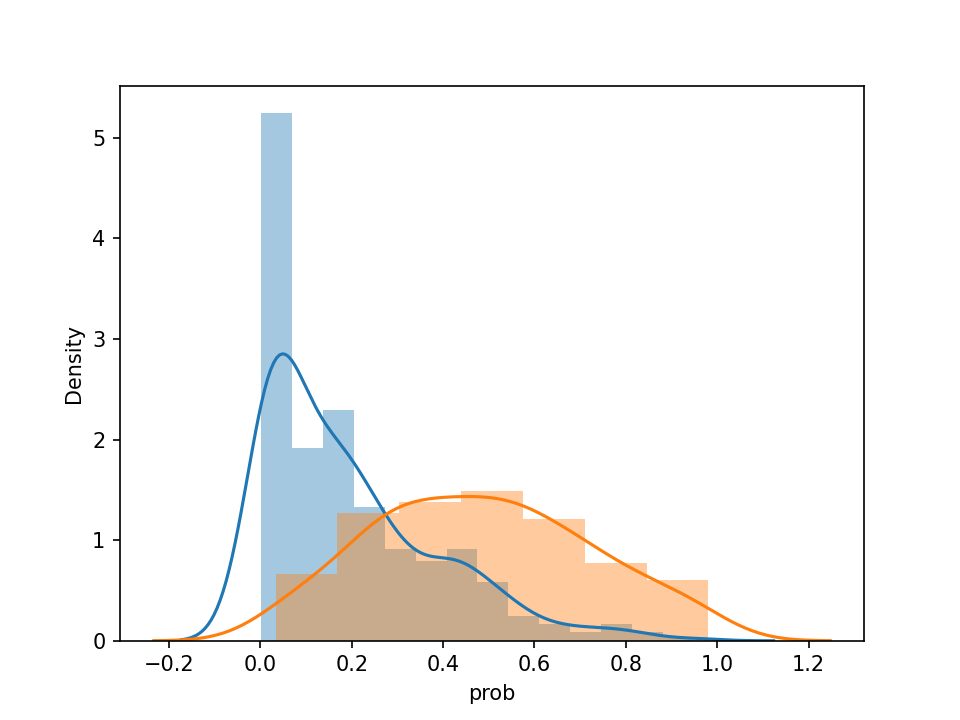

C:\Users\vijay\AppData\Local\Temp\ipykernel_18416\134987762.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_pf.loc[ train_pf.actual == 1, 'prob'])


In [61]:
sns.distplot( train_pf.loc[ train_pf.actual == 0, 'prob'])
sns.distplot(train_pf.loc[ train_pf.actual == 1, 'prob'])
plt.show()